In [47]:
from graphmodels.graphmodel_exp import GraphModel, concatenate_graph_specs
from graphmodels.validation import check_model, check_variable_graph
import pandas as pd
import plotly.express as px
from sklearn.metrics import r2_score

def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X


def pivot(df):
    return df.pivot(index=['Area', 'Year','Item'], columns='GGI_code', values='Value')

def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y

# Manure

# Emissions

In [48]:
# Global variables
to_drop = ['Mules and Asses', 'Sheep and Goats', 'Cattle',
           'Swine', 'Poultry Birds', 'All Animals',
           'Camels and Llamas', 'Chickens']

GWPN2O = 310
GWPCH4 = 21
N2ON_to_NO2 = 1.57
kg_to_Gg = 1e-6

In [49]:
df = pd.read_csv('models/Hermen/data/GY_GE_GU_GM_GP.csv')
data_dict = df_to_dict(pivot(df))

# TMP

In [35]:
TMP_CO2eq_nodes = {'M_LPi': {'type': 'input',
                              'unit': 'kg',
                              'name': 'Manure left on pasture (N content)'},
                   'EF_Li': {'type': 'parameter',
                             'unit': 'kg N2O-N/kg N',
                             'name': 'Implied emission factor for N2O (Manure on pasture)'
                             },
                   'TMP_CO2eq': {'type': 'output',
                                 'unit': 'gigagrams (CO2eq)',
                                 'name': 'Emissions (CO2eq) (Manure on pasture)',
                                 'computation': lambda M_LPi, EF_Li, **kwargs: kg_to_Gg * N2ON_to_NO2 * GWPN2O * (M_LPi * EF_Li)
                                }}

Model = GraphModel(TMP_CO2eq_nodes)

X, y = get_X_y_from_data(Model, data_dict)

check_model(Model, X, y)

Checking computations:
TMP_CO2eq r2: 0.9999968227004328 | TMP_CO2eq corr: 0.9999986115524314


# TMT

In [37]:
TMT_CO2eq_nodes = {'M_Ti': {'type': 'input',
                            'unit': 'kgN',
                            'name': 'Manure treated (N content)',
                            },
                   'EF_Ti': {'type': 'parameter',
                             'unit': 'kg N2O-N/kg N',
                             'name': 'Implied emission factor for N2O (Manure management)'},
                   'EF_CH4Ti': {'type': 'parameter',
                                'unit': 'kg/head',
                                'name': 'Implied emission factor for CH4 (Manure management)'},
                   'TAi': {'type': 'input',
                           'unit': 'head',
                           'name': 'Total animal population'},
                   'E_Ti': {'type': 'variable',
                                 'unit': 'gigagrams',
                                 'name': 'Emissions (N2O) (Manure management)',
                                 'computation': lambda EF_Ti, M_Ti, **kwargs: (EF_Ti * M_Ti) * N2ON_to_NO2 * kg_to_Gg
                                },
                   'E_TCH4i': {'type': 'variable',
                                 'unit': 'gigagrams',
                                 'name': 'Emissions (CH4) (Manure management)',
                                 'computation': lambda EF_CH4Ti, TAi, **kwargs: (EF_CH4Ti * TAi) * kg_to_Gg
                                },
                   'TMT_CO2eq': {'type': 'output',
                                 'unit': 'gigagrams (CO2eq)',
                                 'name': 'Emissions (CO2eq) (Manure management)',
                                 'computation': lambda E_Ti, E_TCH4i, **kwargs: (E_Ti * GWPN2O + E_TCH4i * GWPCH4)
                                }}



Model = GraphModel(TMT_CO2eq_nodes)
X, y = get_X_y_from_data(Model, data_dict)

check_model(Model, X, y)

Checking computations:
E_Ti r2: 0.9999918933374128 | E_Ti corr: 0.9999972009258037
E_TCH4i r2: 0.9999999999814085 | E_TCH4i corr: 0.9999999999907349
TMT_CO2eq r2: 0.9999974557592491 | TMT_CO2eq corr: 0.9999989231823128


# TMA

In [38]:
TMA_CO2eq_nodes = {'M_ASi': {'type': 'input',
                            'unit': 'kgN',
                            'name': 'Manure applied to soils (N content)',
                            },
                   'EF_ASi': {'type': 'parameter',
                              'unit': 'kg N2O-N/kg N',
                              'name': 'Implied emission factor for N2O (Manure applied)'},
                   'TMA_CO2eq': {'type': 'output',
                                 'unit': 'gigagrams (CO2eq)',
                                 'name': 'Emissions (CO2eq) (Manure applied)',
                                 'computation': lambda EF_ASi, M_ASi, **kwargs:  GWPN2O * N2ON_to_NO2 * kg_to_Gg * (EF_ASi * M_ASi) 
                                 }
                   }

Model = GraphModel(TMA_CO2eq_nodes)

X, y = get_X_y_from_data(Model, data_dict)

check_model(Model, X, y)

Checking computations:
TMA_CO2eq r2: 0.9999929200658959 | TMA_CO2eq corr: 0.9999996994033535


# TEE

In [39]:
TEE_CO2eq_nodes = {'EF_EEi': {'type': 'input',
                              'unit': 'kg CH4 / head',
                              'name': 'Implied emission factor for CH4 (Enteric)'},
                   'TAi': {'type': 'input',
                           'unit': 'head',
                           'name': 'Total animal population'},
                   'TEE_CO2eq': {'type': 'output',
                                 'unit': 'gigagrams (CO2eq)',
                                 'name': 'Emissions (CO2eq) (Enteric)',
                                 'computation': lambda TAi, EF_EEi, **kwargs: kg_to_Gg * GWPCH4 * (TAi * EF_EEi)
                                 }
                  }


Model = GraphModel(TEE_CO2eq_nodes)
X, y = get_X_y_from_data(Model, data_dict)

check_model(Model, X, y)

Checking computations:
TEE_CO2eq r2: 1.0 | TEE_CO2eq corr: 1.0


# FE

In [40]:
FE_CO2eq_nodes = {
                  'IN_F': {'type': 'input',
                           'unit': 'kg',
                           'name': 'Agricultural Use in nutrients',
                           },
                  'EF_F': {'type': 'parameter',
                           'unit': 'kg N2O-N/kg N',
                           'name': 'Implied emission factor for N2O (Synthetic fertilizers)'},
                  'FE_CO2eq': {'type': 'output',
                               'unit': 'gigagrams (CO2eq)',
                               'name': 'Emissions (CO2eq) (Synthetic fertilizers)',
                               'computation': lambda EF_F, IN_F, **kwargs: GWPN2O * N2ON_to_NO2 * kg_to_Gg *(EF_F * IN_F)
                              }
                 }


Model = GraphModel(FE_CO2eq_nodes)

X, y = get_X_y_from_data(Model, data_dict)

check_model(Model, X, y)

Checking computations:
FE_CO2eq r2: 0.9999878268614328 | FE_CO2eq corr: 0.9999941597487292


# TOTAL GRAPH

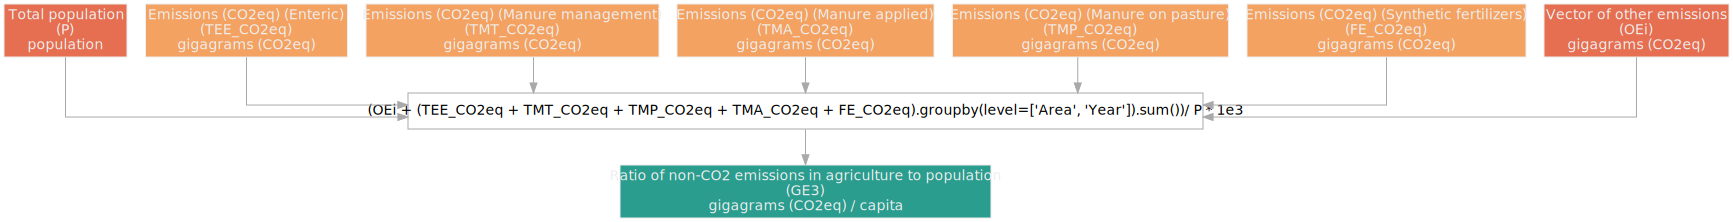

In [41]:
GE3_nodes = {'P': {'type': 'input', 'unit': 'population', 'name': 'Total population'},
             'TEE_CO2eq': {'type': 'variable',
                           'unit': 'gigagrams (CO2eq)',
                           'name': 'Emissions (CO2eq) (Enteric)'},
             'TMT_CO2eq': {'type': 'variable',
                           'unit': 'gigagrams (CO2eq)',
                           'name': 'Emissions (CO2eq) (Manure management)'},
             'TMA_CO2eq': {'type': 'variable',
                           'unit': 'gigagrams (CO2eq)',
                           'name': 'Emissions (CO2eq) (Manure applied)'},
             'TMP_CO2eq': {'type': 'variable',
                           'unit': 'gigagrams (CO2eq)',
                           'name': 'Emissions (CO2eq) (Manure on pasture)'},
             'FE_CO2eq': {'type': 'variable',
                          'unit': 'gigagrams (CO2eq)',
                          'name': 'Emissions (CO2eq) (Synthetic fertilizers)'},
             'OEi': {'type': 'input',
                     'unit': 'gigagrams (CO2eq)',
                     'name': 'Vector of other emissions'},
             'GE3': {'type': 'output',
                     'unit': 'gigagrams (CO2eq) / capita',
                     'name': 'Ratio of non-CO2 emissions in agriculture to population',
                     'computation': lambda OEi, TEE_CO2eq, TMT_CO2eq, TMP_CO2eq, TMA_CO2eq, FE_CO2eq, P, **kwargs: (OEi + (TEE_CO2eq + TMT_CO2eq + TMP_CO2eq + TMA_CO2eq + FE_CO2eq).groupby(level=['Area', 'Year']).sum())/ P * 1e3}}


GraphModel(GE3_nodes).draw()

In [43]:
nodes = concatenate_graph_specs([#GE3_nodes, 
                                 TEE_CO2eq_nodes, TMA_CO2eq_nodes, TMT_CO2eq_nodes, TMP_CO2eq_nodes, FE_CO2eq_nodes])

Model = GraphModel(nodes)#.draw()

In [44]:
#Model.draw()

In [45]:
X, y = get_X_y_from_data(Model, data_dict)

check_model(Model, X, y)

Checking computations:
E_Ti r2: 0.9999918933374128 | E_Ti corr: 0.9999972009258037
E_TCH4i r2: 0.9999999999814085 | E_TCH4i corr: 0.9999999999907349
TEE_CO2eq r2: 1.0 | TEE_CO2eq corr: 1.0
TMA_CO2eq r2: 0.9999929200658959 | TMA_CO2eq corr: 0.9999996994033535
TMT_CO2eq r2: 0.9999974557592491 | TMT_CO2eq corr: 0.9999989231823128
TMP_CO2eq r2: 0.9999968227004328 | TMP_CO2eq corr: 0.9999986115524314
FE_CO2eq r2: 0.9999878268614328 | FE_CO2eq corr: 0.9999941597487292
